<h1>A pharmacy in Milan: where to start</h1>
<h2>A data analysis for finding the best place in Milan for a new pharmacy business.</h2>
<h4><em>Applied Data Science Capstone by IBM/Coursera</em></h4>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Data Analysis](#analysis)
* [Results discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

In this project we will try to analyze some data for finding the **best neighborhood in Milan** for starting a new **pharmacy** business. In this 1 million and 300 thousand people city there are indeed more than with 400 pharmacies and we have to struggle with multiple factors when trying to understand which of the 88 neighborhoods would be nice for a new one. Thus, **if you want to open a pharmacy in Milan** or if you just want to better understand this business situation in the city, this analysis is for you.
We will go through three important factors for reaching our aim.
* For gaining as many customers as possible we need a place with few competitors: which neighborhoods have got the **least number of pharmacies**?
* For reaching a high number of customers we need to serve a highly populated area: which neighborhoods have got the **highest population**?
* And finally, for being efficient we could need a place with some pharmaceutical wholesaler: which neighborhoods have got the **highest number of pharmaceutical distributors**? 

These three questions will guide our analysis and will help to find the right data to analyze for our goal. We will use data science tools for answering the initial question: **where is the best place in Milan for starting a new pharmacy business?**


## 2. Data <a name="data"></a>

Basing our analysis on the three previous questions, we now need to find three key data:
* Number of pharmacies for every neighborhood
* Population of every neighborhood
* Number of pharmaceutical wholesalers for every neighborhood

All the information on neighborhood ID, coordinates, population and more, can be found on the official portal of **Milan municipality** (http://dati.comune.milano.it/), a site with many **open data-sets** about the city. There is also a nice georeferenced dataset with all the information about pharmaceutical distributors around the city.
We will then find the number of pharmacies thanks to **Foursquare API**, sending some request for a specific venue category (pharmacy) near a spot (center of neighborhood). 
All these datasets need to be **pre-processed** for fitting our needs. We are going to use **Python** libraries for this aim and **Excel** for fast preparing some tables. All data will be then loaded on a public url.

*Please, note that Milan neighborhoods are called NIL (Nuclei di Idendità Locale, that means Local Identity Nuclea).*


In [1]:
#Import all Python necessary libraries for data acquisition and processing
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import json
import requests 
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

### Pharmaceutical wholesaler distributors

Let's start reading the pharmaceutical distributors CSV dataset by Milan Municipality and filling a Pandas dataframe with it. Note that i uploaded the dataset on a personal shared url. 

In [2]:
distributors = pd.read_csv('http://asvalon.altervista.org/wp-content/uploads/2020/05/distributori-di-farmaci_v3_geo.csv', sep=';')
distributors.head()

,CODICEIDENTIFICATIVOSITO,DENOMINAZIONESITOLOGISTICO,INDIRIZZO,PARTITAIVA,CAP,CODICECOMUNEISTAT,DESCRIZIONECOMUNE,CODICEPROVINCIAISTAT,SIGLAPROVINCIA,DESCRIZIONEPROVINCIA,...,DESCRIZIONEDISTRIBUTORE,LOCALIZE,NUMEROCOMPLETO,CODICE_VIA,MUNICIPIO,ID_NIL,NIL,LONG_WGS84,LAT_WGS84,Location
0,18,Stabilimento di Milano,via matteo civitali 1,748210150,20148,15146,Milano,15,MI,Milano,...,Produttore,1,1,6569.0,7.0,57.0,SELINUNTE,9.136590,45.468945,"45.4689449631, 9.13658985457"
1,27,Lofarma S.p.A.,"viale cassala, 40",713510154,20143,15146,Milano,15,MI,Milano,...,Produttore,1,40,5275.0,6.0,44.0,NAVIGLI,9.165970,45.444011,"45.4440112757, 9.16597016441"
2,28,Mipharm S.p.A.,"via b. quaranta, 12",12304990158,20141,15146,Milano,15,MI,Milano,...,Produttore,1,NaN,NaN,5.0,38.0,RIPAMONTI,9.204009,45.436331,"45.4363314, 9.2040092"
3,30,SCHWARZ PHARMA S.p.A.,"via gadames, snc",7254500155,20151,15146,Milano,15,MI,Milano,...,Produttore,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,LA COMMERCIALE FARMACEUTICA srl,via desenzano 6/a,55560775,20146,15146,Milano,15,MI,Milano,...,Grossista,1,6A,6610.0,7.0,52.0,BANDE NERE,9.140103,45.462419,"45.4624185522, 9.14010264607"


Don't worry about Italian, cos we are going to clean a lot of unnecessary data from this set and make it more clear and understandable.
Note that important data are on the columns:
* DENOMINAZIONESITOLOGISTICO, that is the name of the distributor
* ID_NIL, that is the code of the neighborhood
* NIL, that is the name of the neighborhood
* LONG_WGS84, the longitude of the site
* LAT_WGS84, the latitude of the site

Now let's clean the dataset and rearrange columns. Some rows are missing location data: we are dropping them.

In [3]:
distributors = distributors[['DENOMINAZIONESITOLOGISTICO','ID_NIL','NIL','LONG_WGS84','LAT_WGS84']]
distributors = distributors.dropna()
distributors = distributors[['DENOMINAZIONESITOLOGISTICO','ID_NIL','NIL','LAT_WGS84','LONG_WGS84']]
distributors.head()

,DENOMINAZIONESITOLOGISTICO,ID_NIL,NIL,LAT_WGS84,LONG_WGS84
0,Stabilimento di Milano,57.0,SELINUNTE,45.468945,9.136590
1,Lofarma S.p.A.,44.0,NAVIGLI,45.444011,9.165970
2,Mipharm S.p.A.,38.0,RIPAMONTI,45.436331,9.204009
4,LA COMMERCIALE FARMACEUTICA srl,52.0,BANDE NERE,45.462419,9.140103
5,V.I.M. srl,52.0,BANDE NERE,45.462419,9.140103


Now, let's visualize the location site of all the distributors with Python Folium library. Click on the marker for the name.

In [4]:
#Define coordinates of Milan
milan_coords = [45.4668, 9.1905]

#Create the map of Milan
milan_map_distributors = folium.Map(location = milan_coords, zoom_start = 12)

#Ad markers to the map for pharmaceutical wholesaler distributors in Milan
for i in range (0,72):
    dist_loc = distributors.iloc[i,3:5] #location of distributor
    dist_name = distributors.iloc[i,0] #name of distributor 
    folium.Marker(dist_loc, popup = dist_name).add_to(milan_map_distributors)
#Display the map
milan_map_distributors

Now we need to set the ID_NIL code as an integer type variable.

In [5]:
distributors['ID_NIL'] = distributors['ID_NIL'].astype(int)
distributors.head()

,DENOMINAZIONESITOLOGISTICO,ID_NIL,NIL,LAT_WGS84,LONG_WGS84
0,Stabilimento di Milano,57,SELINUNTE,45.468945,9.136590
1,Lofarma S.p.A.,44,NAVIGLI,45.444011,9.165970
2,Mipharm S.p.A.,38,RIPAMONTI,45.436331,9.204009
4,LA COMMERCIALE FARMACEUTICA srl,52,BANDE NERE,45.462419,9.140103
5,V.I.M. srl,52,BANDE NERE,45.462419,9.140103


Time to count the number of distributors for every neighborhood. Note that we represent the neighborhood with the ID_NIL code and that not every neighborhood has got some wholesaler.

In [6]:
dist_freq = distributors['ID_NIL'].value_counts()
dist_freq

13    9
79    7
30    6
21    6
15    4
68    3
52    3
48    3
80    2
38    2
28    2
20    2
26    2
44    2
12    2
22    1
18    1
16    1
11    1
19    1
33    1
23    1
35    1
36    1
51    1
57    1
60    1
61    1
67    1
70    1
75    1
10    1
Name: ID_NIL, dtype: int64

We then fill an excel file with the obtained data. In particular we are using an excel file that you can find on Milan Municipality portal, with information about every neighborhoods population. We simply add a column with the number of distributors. 

### Population

We now have an excel file with:
* ID_NIL and NIL name, for identifying every neighborhood
* Latitude and Longitude of the neighborhood
* dist_freq, that is the number of pharmaceutical distributors in the neighborhood
* pop, that is the population of the neighborhood

Let's read it and fill a Pandas dataframe.

In [7]:
nil_data = pd.read_excel('http://asvalon.altervista.org/wp-content/uploads/2020/05/NIL_coo.xlsx')
nil_data.head()

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop
0,17,Adriano,45.514271,9.245198,0,16947
1,80,Affori,45.513926,9.173530,2,24893
2,55,Baggio,45.462387,9.086922,0,29661
3,52,Bande_Nere,45.461504,9.136485,3,44230
4,46,Barona,45.438652,9.158203,0,17018


Let's now visualiza a map with neighborhood boarder and names. We are using a choropleth map build with a geojson file from gihub with Milan neighborood. The intensity of the color is based on the number of distributors in that neighborhood.

In [8]:
#Define coordinates of Milan
milan_coords = [45.4668, 9.1905]

#Create the map of Milan
milan_map_nil = folium.Map(location = milan_coords, zoom_start = 12)

#Ad markers to the map for pharmaceutical wholesaler distributors in Milan
for i in range (0,88):
    nil_loc = nil_data.iloc[i,2:4] #location of nil
    nil_name = nil_data.iloc[i,1] #name of nil
    folium.Marker(nil_loc, popup = nil_name).add_to(milan_map_nil)
    
milan_geo = r'https://raw.githubusercontent.com/abahgat/opendata-milano/master/geojson/quartieri.geojson'

milan_map_nil.choropleth(
    geo_data=milan_geo,
    data=nil_data,
    columns=['ID_NIL','dist_freq'],
    key_on='feature.properties.ID_NIL',
    fill_color='YlOrRd'
)
#Display the map
milan_map_nil


We are now going to visualize a choropleth map where the intensity represents the population of the neighborhood.

In [9]:
milan_map_pop = folium.Map(location = milan_coords, zoom_start = 12)
milan_map_pop.choropleth(
    geo_data=milan_geo,
    data=nil_data,
    columns=['ID_NIL','pop'],
    key_on='feature.properties.ID_NIL',
    fill_color='OrRd'
)
# display map
milan_map_pop

### Pharmacies number

It's now time for calling Foursquare API and finding how many pharmacies are located near every neighborhood.  
Let's start reorganizing our dataframe sorting it by ID_NIL code.

In [10]:
nil_data = nil_data.sort_values('ID_NIL')
nil_data.head()

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop
20,1,Duomo,45.464181,9.189738,0,16882
8,2,Brera,45.471236,9.187407,0,18199
29,3,Giardini_Porta_Venezia,45.474424,9.199361,0,38
32,4,Guastalla,45.459333,9.202480,0,15050
84,5,Vigentina,45.431374,9.187316,0,41216


We are going to send search requests to Foursquare, looking for pharmacy venues in the radius of 800 meters near every neighborhood. Note that we are not interested in all the data contained in the response, but just in the number of found venues.   
We put the results into a CSV file and we save it, so we won't have to call Foursquare API every time we run the program.

In [11]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [12]:
import json
from pandas.io.json import json_normalize

pharma_num = pd.DataFrame(columns=['ID_NIL','NIL','pharma_num'])

LIMIT = 100
intent = 'checkin'
radius = 800
categoryId = '4bf58dd8d48988d10f951735'

for i in range(0,88):
    
    nil_latitude = nil_data.iloc[i,2]
    nil_longitude = nil_data.iloc[i,3]
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&intent={}&radius={}&limit={}&categoryId={},'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        nil_latitude, 
        nil_longitude,
        intent,
        radius, 
        LIMIT,
        categoryId)
    results = requests.get(url).json()["response"]['venues']
    df = pd.DataFrame(results)
    pharma_num = pharma_num.append({'ID_NIL':nil_data.iloc[i,0],'NIL':nil_data.iloc[i,1],'pharma_num':len(df.index)},ignore_index=True)
print(pharma_num)  

   ID_NIL                     NIL pharma_num
0       1                   Duomo         42
1       2                   Brera         29
2       3  Giardini_Porta_Venezia         24
3       4               Guastalla         26
4       5               Vigentina          6
..    ...                     ...        ...
83     84              Parco_Nord          2
84     85     Parco_delle_Abbazie          0
85     86       Parco_dei_Navigli          0
86     87      Parco_Agricolo_Sud          0
87     88    Parco_Bosco_in_città          0

[88 rows x 3 columns]


### Final dataset

We now have got every data we need and we put all into a dataframe where we have 
* neighborhoods data
* number of distributor
* population
* number of pharmacies

In [13]:
pharma_num_dropped = pharma_num.drop('NIL',axis=1)
final_data = pd.merge(left=nil_data, right=pharma_num_dropped, left_on='ID_NIL', right_on='ID_NIL')
final_data.head(10)

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num
0,1,Duomo,45.464181,9.189738,0,16882,42
1,2,Brera,45.471236,9.187407,0,18199,29
2,3,Giardini_Porta_Venezia,45.474424,9.199361,0,38,24
3,4,Guastalla,45.459333,9.202480,0,15050,26
4,5,Vigentina,45.431374,9.187316,0,41216,6
5,6,Ticinese,45.454583,9.187842,0,19654,37
6,7,Magenta_San_Vittore,45.460082,9.171333,0,17468,29
7,8,Parco_Sempione,45.472098,9.177224,0,2,29
8,9,Garibaldi_Repubblica,45.480284,9.198341,0,5599,24
9,10,Centrale,45.483971,9.206097,1,18564,29


## 3. Methodology <a name="methodology"></a>

Now we can visualize data  in a 3D scatter plot for looking for good candidates.

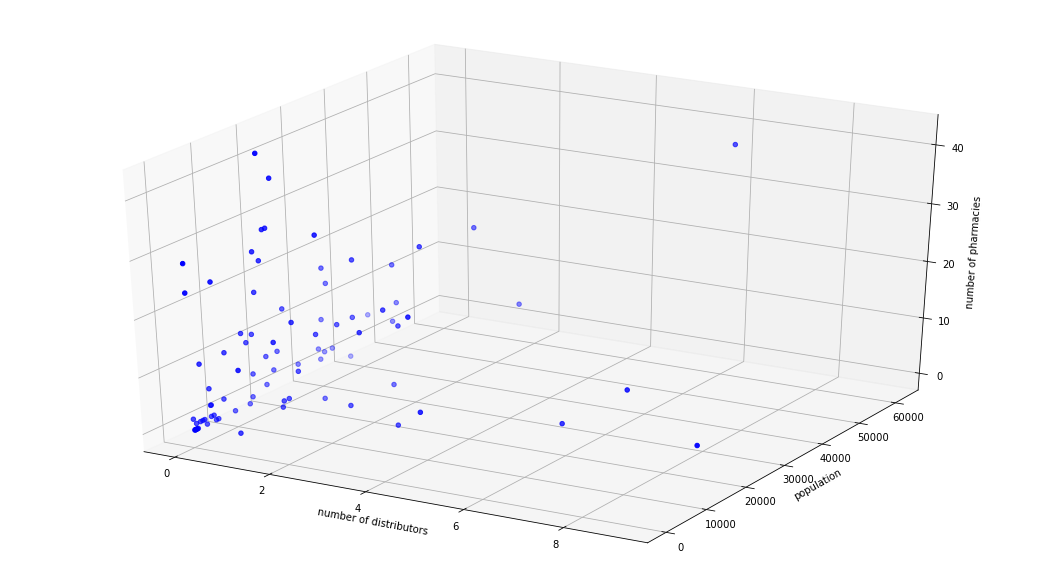

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = final_data[['dist_freq']].values.tolist()
y = final_data[['pop']].values.tolist()
z = final_data[['pharma_num']].values.tolist()

ax.scatter(x, y, z, c = 'b', marker='o')
ax.set_xlabel('number of distributors')
ax.set_ylabel('population')
ax.set_zlabel('number of pharmacies')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

We can see three nice points with average population, a hight number of wholesalers and low number of existing pharmacies. Let's look at a 2D scatter plot with the labled name of these trhee candidates.

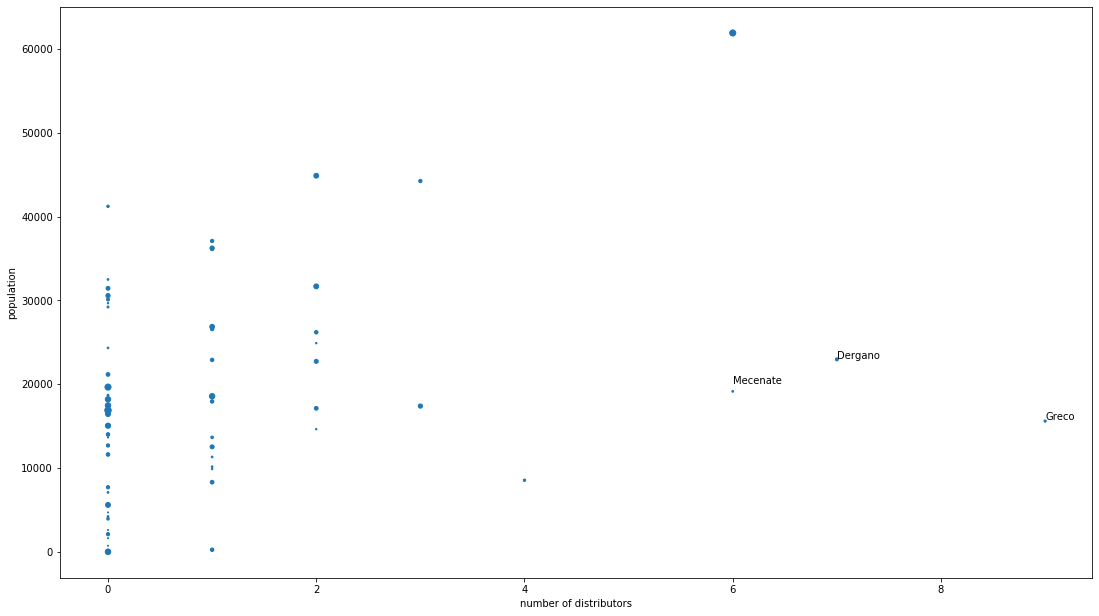

In [15]:
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, s=z)
ax.set_xlabel('number of distributors')
ax.set_ylabel('population')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.text(6,20000,'Mecenate')
plt.text(7,23000,'Dergano')
plt.text(9,15800,'Greco')
plt.show()

_Mecenate_, _Dergano_ and _Greco_ seems to have nice features! 

It's time to go deeper into our data, so let's clean them a little bit more. We don't need geodata for plots and machine learning algorithm, so we are dropping them as well as the ID_NIL code, not necessary for the k-means.

In [16]:
final_data_no_coordiates = final_data.drop(['NIL','Latitude','Longitude'],axis=1)
final_data_no_coordiates

,ID_NIL,dist_freq,pop,pharma_num
0,1,0,16882,42
1,2,0,18199,29
2,3,0,38,24
3,4,0,15050,26
4,5,0,41216,6
...,...,...,...,...
83,84,0,100,2
84,85,0,445,0
85,86,0,289,0
86,87,0,302,0


In [17]:
final_data_clustering = final_data_no_coordiates.drop(['ID_NIL'],axis=1)
final_data_clustering

,dist_freq,pop,pharma_num
0,0,16882,42
1,0,18199,29
2,0,38,24
3,0,15050,26
4,0,41216,6
...,...,...,...
83,0,100,2
84,0,445,0
85,0,289,0
86,0,302,0


Now we have to procede with some data normalization for better compare them and for computationl reasons. I used a _scaling to unit_ normalization.

In [18]:
#Normalization
final_data_clustering_norm = final_data_clustering
final_data_clustering_norm['dist_freq'] = final_data_clustering_norm['dist_freq']/max(final_data_clustering_norm['dist_freq'])
final_data_clustering_norm['pop']= final_data_clustering_norm['pop']/max(final_data_clustering_norm['pop'])
final_data_clustering_norm['pharma_num']= final_data_clustering_norm['pharma_num']/max(final_data_clustering_norm['pharma_num'])
final_data_clustering_norm

,dist_freq,pop,pharma_num
0,0.0,0.272770,1
1,0.0,0.294049,0.690476
2,0.0,0.000614,0.571429
3,0.0,0.243169,0.619048
4,0.0,0.665945,0.142857
...,...,...,...
83,0.0,0.001616,0.047619
84,0.0,0.007190,0
85,0.0,0.004669,0
86,0.0,0.004880,0


Time to understand how much cluster we want to obtain by the algorithm. Here I used the **Elbow Method**, both with Inertia and Distorsion, testing for k values in range (1,15). We can see that there is no evident elbow, but **k=8** seems to be a nice choice.

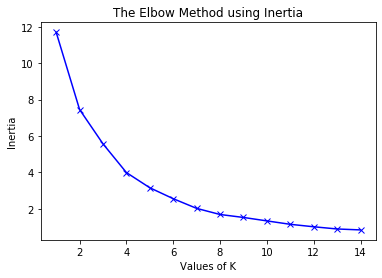

In [19]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(final_data_clustering_norm) 
    kmeanModel.fit(final_data_clustering_norm)     
      
    distortions.append(sum(np.min(cdist(final_data_clustering_norm, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / final_data_clustering_norm.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(final_data_clustering_norm, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / final_data_clustering_norm.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


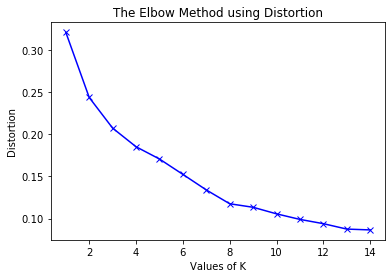

In [20]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

Now that we made the choice, we can run the k-means algorithm and label every NIL with one of the 8 cluster's labels.

In [21]:
kclusters = 8
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(final_data_clustering_norm)
kmeans.labels_

array([2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 3, 3, 7, 6, 1, 1, 1, 1, 3, 3, 5, 3,
       1, 4, 1, 3, 2, 3, 4, 7, 4, 4, 1, 4, 6, 0, 0, 1, 4, 4, 1, 6, 0, 0,
       0, 1, 4, 1, 3, 0, 3, 3, 0, 4, 6, 6, 3, 0, 0, 0, 1, 4, 4, 4, 6, 4,
       0, 3, 3, 0, 6, 4, 4, 1, 4, 6, 1, 4, 7, 1, 4, 4, 1, 4, 4, 4, 4, 4],
      dtype=int32)

Here we put all the usefull information together in a dataframe where every NIL is clusterized (labeled).

In [23]:
final_data['label'] = kmeans.labels_
final_data

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
0,1,Duomo,45.464181,9.189738,0,16882,42,2
1,2,Brera,45.471236,9.187407,0,18199,29,2
2,3,Giardini_Porta_Venezia,45.474424,9.199361,0,38,24,2
3,4,Guastalla,45.459333,9.202480,0,15050,26,2
4,5,Vigentina,45.431374,9.187316,0,41216,6,6
...,...,...,...,...,...,...,...,...
83,84,Parco_Nord,45.516508,9.183165,0,100,2,4
84,85,Parco_delle_Abbazie,45.413736,9.229704,0,445,0,4
85,86,Parco_dei_Navigli,45.424765,9.144063,0,289,0,4
86,87,Parco_Agricolo_Sud,45.447356,9.061052,0,302,0,4


We can also visualize NIL's clustering on a nice map with different colored spots for every cluster.

In [24]:
# create map
map_clusters_final = folium.Map(location=milan_coords, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_data['Latitude'], final_data['Longitude'], final_data['NIL'], final_data['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters_final)
       
map_clusters_final

## 4. Data Analysis <a name="analysis"></a>

Now we have all we need for analyze our data and see if the three candidates are confirmed by the k-means. Let's see how the clusterization performed looking into every cluster.

### Cluster 0
Here we see neighborhoods with average and high population, really low number of distributors and medium-hight number of competitors.

In [25]:
final_data.loc[final_data['label'] == 0] #Cluster 0

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
35,36,Scalo_Romana,45.446109,9.208176,1,12525,16,0
36,37,Ex_Om_Morivione,45.441853,9.182290,0,7710,11,0
42,43,Tibaldi,45.444557,9.183138,0,11618,13,0
43,44,Navigli,45.445741,9.176393,2,17122,14,0
44,45,San_Cristoforo,45.445764,9.150085,0,12691,11,0
49,50,Tortona,45.451789,9.163661,0,15049,19,0
52,53,Lorenteggio,45.450124,9.142573,0,14016,12,0
57,58,De_Angeli_Monte_Rosa,45.470806,9.154784,0,21163,14,0
58,59,Tre_Torri,45.476883,9.161572,0,2112,11,0
59,60,San_Siro,45.475732,9.137811,1,255,12,0


### Cluster 1
Here we have neighborhoods with average or hight population, low number of distributors and average number of competitors.

In [26]:
final_data.loc[final_data['label'] == 1] #Cluster 1

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
14,15,Bicocca,45.519352,9.208257,4,8543,6,1
15,16,Viale_Monza,45.499220,9.220878,1,13658,7,1
16,17,Adriano,45.514271,9.245198,0,16947,2,1
17,18,Parco_Lambro_Cimiano,45.495700,9.248752,1,19546,0,1
22,23,Lambrate,45.483866,9.251253,1,11319,3,1
24,25,Corsica,45.462110,9.231037,0,19619,7,1
32,33,Rogoredo,45.435575,9.240820,1,10158,3,1
37,38,Ripamonti,45.424672,9.203590,2,14633,2,1
40,41,Gratosoglio_Ticinello,45.413196,9.171556,0,18679,4,1
45,46,Barona,45.438652,9.158203,0,17018,7,1


### Cluster 2
Here there are neighborhoods with average population, extremely low number of distributors and hight number of competitors.

In [27]:
final_data.loc[final_data['label'] == 2] #Cluster 2

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
0,1,Duomo,45.464181,9.189738,0,16882,42,2
1,2,Brera,45.471236,9.187407,0,18199,29,2
2,3,Giardini_Porta_Venezia,45.474424,9.199361,0,38,24,2
3,4,Guastalla,45.459333,9.202480,0,15050,26,2
5,6,Ticinese,45.454583,9.187842,0,19654,37,2
6,7,Magenta_San_Vittore,45.460082,9.171333,0,17468,29,2
7,8,Parco_Sempione,45.472098,9.177224,0,2,29,2
8,9,Garibaldi_Repubblica,45.480284,9.198341,0,5599,24,2
9,10,Centrale,45.483971,9.206097,1,18564,29,2
26,27,Porta_Romana,45.451434,9.203400,0,16437,24,2


### Cluster 3
Here we see neighborhoods with high population, really low number of distributors and medium-hight number of competitors.

In [28]:
final_data.loc[final_data['label'] == 3] #Cluster 3

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
10,11,Isola,45.487665,9.189810,1,22896,12,3
11,12,Maciachini_Maggiolina,45.497702,9.185043,2,26192,12,3
18,19,Padova,45.501925,9.237570,1,37081,11,3
19,20,Loreto,45.487388,9.215220,2,44863,23,3
21,22,Città_studi,45.476981,9.225648,1,36232,18,3
25,26,XXII_Marzo,45.462187,9.215737,2,31667,24,3
27,28,Umbria_Molise,45.454399,9.215669,2,22726,16,3
48,49,Giambellino,45.453616,9.140982,0,31435,15,3
50,51,Washington,45.462999,9.157094,1,26853,22,3
51,52,Bande_Nere,45.461504,9.136485,3,44230,11,3


### Cluster 4
Here we see neighborhoods with low population, really low number of distributors and low number of competitors. 

In [29]:
final_data.loc[final_data['label'] == 4] #Cluster 4

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
23,24,Parco_Forlanini_Ortica,45.465011,9.264063,0,2608,1,4
28,29,Ortomercato,45.446506,9.229497,0,4217,3,4
30,31,Parco_Monluè,45.457063,9.255879,0,5170,0,4
31,32,Triulzo_Superiore,45.431667,9.260833,0,1631,1,4
33,34,Chiaravalle,45.416523,9.240252,0,1055,0,4
38,39,Quintosole,45.404894,9.204043,0,855,0,4
39,40,Ronchetto_delle_Rane,45.402016,9.181960,0,734,1,4
46,47,Cantalupa,45.418440,9.157991,0,510,0,4
53,54,Muggiano,45.449583,9.072860,0,3104,0,4
61,62,Quinto_Romano,45.476930,9.089101,0,4706,1,4


### Cluster 5
Here we see neighborhoods with average and high population, good number of distributors and medium-hight number of competitors.

In [30]:
final_data.loc[final_data['label'] == 5] #Cluster 5

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
20,21,Buenos_Aires_Venezia,45.4796,9.209893,6,61891,37,5


### Cluster 6
Here we see neighborhoods with high population, really low number of distributors and low number of competitors.

In [31]:
final_data.loc[final_data['label'] == 6] #Cluster 6

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
4,5,Vigentina,45.431374,9.187316,0,41216,6,6
13,14,Niguarda_Cà_Granda,45.517180,9.192075,0,36795,0,6
34,35,Lodi_Corvetto,45.440407,9.223870,1,36085,8,6
41,42,Stadera,45.434000,9.178277,0,30100,9,6
54,55,Baggio,45.462387,9.086922,0,29661,2,6
55,56,Forze_Armate,45.458074,9.113045,0,24329,3,6
64,65,Gallaratese,45.499966,9.110788,0,32494,3,6
70,71,Villapizzone,45.500819,9.144538,0,29209,4,6
75,76,Quarto_Oggiaro,45.511583,9.143635,0,30634,3,6


### Cluster 7
Here we have neighborhoods with average population, hight number of distributors and low number of competitors.

In [32]:
final_data.loc[final_data['label'] == 7] #Cluster 7

,ID_NIL,NIL,Latitude,Longitude,dist_freq,pop,pharma_num,label
12,13,Greco,45.504804,9.212853,9,15600,5,7
29,30,Mecenate,45.450967,9.250841,6,19143,3,7
78,79,Dergano,45.504204,9.176218,7,22960,9,7


## 5. Results discussion <a name="results"></a>

The analysis of the k-means results confirm that there is a cluster (number 7) of 3 neighborhoods which are good candidates for being the best places for starting a new pharmacy business, with a good number of population, proximity to wholesalers and low number of competitors, as seen in the previous scatter plots. 
There is also something more: we discovered that there are some neighborhoods in which there are the worst condition. They are the ones in the clusters number 2, with an extremely hight number of competitors, a low-average population and no wholesalers. 
Another interesting result is the cluster number 6. Here we can find NILs with no distributors, but with a really hight number of possible customers and an under-average number of competitors.

## 6. Conclusion <a name="conclusion"></a>

The main aim of these project was to identify the better neighborhood in Milan for a possible stakeholder interested in opening a new pharmacy or for everyone interested in understanding how this business is going in the city. I found that there are two possible choices. 
The first one is the one regarding cluster number 7: these neighborhoods are the best for everyone looking for a place with an average number of possible customers, low number of competitors but hight number of wholesalers, that means fast drugs supply.
The second one is the one regarding cluster number 6: these neighborhoods are the best for everyone looking for a place with a really hight number of possible customers, low number of competitors but no close wholesaler, that may mean slower supply procedures.